## loading dataset

In [ ]:
!pip install pandas seaborn matplotlib numpy


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

DATA_PATH = '/"../data/Copy of complaints.csv'
df = pd.read_csv(DATA_PATH)

print("Original DataFrame Info:")
df.info()
print("\nOriginal DataFrame Head:")
print(df.head())

/tmp/ipython-input-5-2761560347.py:15: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Copy of complaints.csv")


Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), obje

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## initial eda to explore the data

In [ ]:

print("\nMissing Values before cleaning:")
print(df.isnull().sum())


Missing Values before cleaning:
Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        839522
Consumer complaint narrative    6629041
Company public response         4770207
Company                               0
State                             54516
ZIP code                          30228
Tags                            8981029
Consumer consent provided?      1649561
Submitted via                         0
Date sent to company                  0
Company response to consumer         20
Timely response?                      0
Consumer disputed?              8841498
Complaint ID                          0
dtype: int64


## analyze complaint distribution across products

/tmp/ipython-input-7-468977703.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Product', order=df['Product'].value_counts().index, palette='viridis')


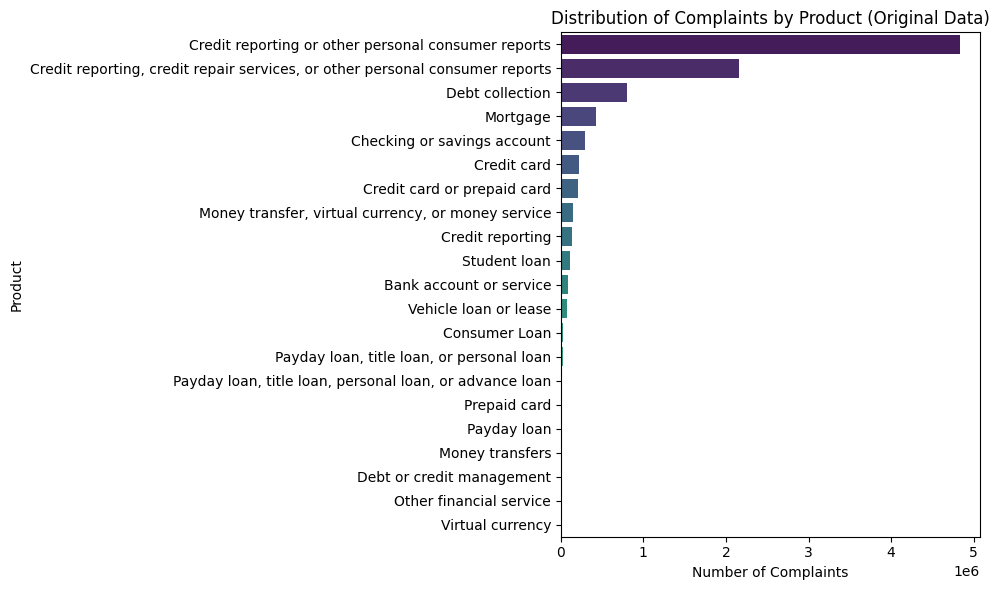

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Product', order=df['Product'].value_counts().index, palette='viridis')
plt.title('Distribution of Complaints by Product (Original Data)')
plt.xlabel('Number of Complaints')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

## analyze and plot complaint word count


Narrative Word Count Statistics:
count    9.609797e+06
mean     5.446667e+01
std      1.497672e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_word_count, dtype: float64


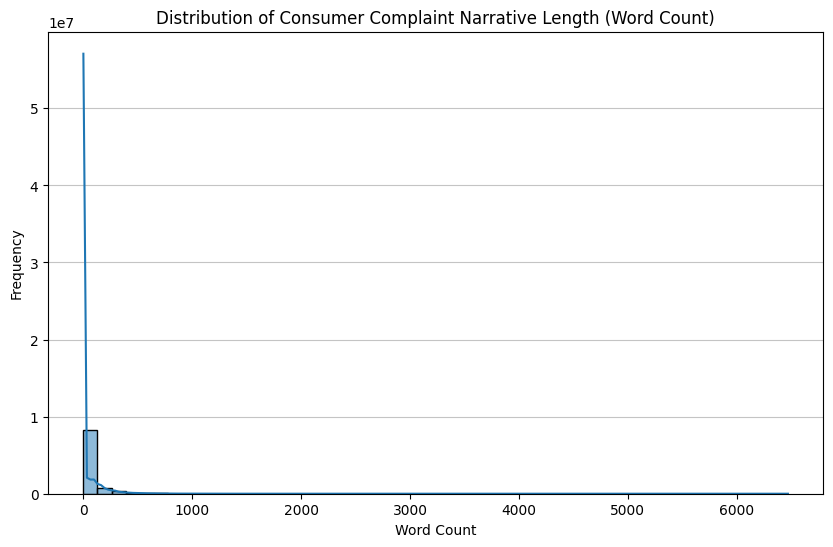


Narratives with 0 words (empty/NaN): 6629041
Shortest narrative (non-empty): 1
Longest narrative: 6469


In [ ]:

def word_count(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

df['narrative_word_count'] = df['Consumer complaint narrative'].apply(word_count)

print("\nNarrative Word Count Statistics:")
print(df['narrative_word_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['narrative_word_count'], bins=50, kde=True)
plt.title('Distribution of Consumer Complaint Narrative Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


print(f"\nNarratives with 0 words (empty/NaN): {df[df['narrative_word_count'] == 0].shape[0]}")
print(f"Shortest narrative (non-empty): {df[df['narrative_word_count'] > 0]['narrative_word_count'].min()}")
print(f"Longest narrative: {df['narrative_word_count'].max()}")

## count complaints with and without narrative

In [ ]:
complaints_with_narrative = df['Consumer complaint narrative'].dropna().shape[0]
complaints_without_narrative = df.shape[0] - complaints_with_narrative
print(f"\nComplaints with narratives: {complaints_with_narrative}")
print(f"Complaints without narratives: {complaints_without_narrative}")


Complaints with narratives: 2980756
Complaints without narratives: 6629041


## filter data as per project requirements

In [ ]:

product_mapping = {
    'Credit card': 'Credit card',
    'Payday loan, title loan, or personal loan': 'Personal loan',
    'Bank account or service': 'Savings account',
    'Money transfer, virtual currency, or money service': 'Money transfers',
    'Student loan': 'Personal loan',
    'Savings account': 'Savings account',
    'Buy Now, Pay Later': 'Buy Now, Pay Later' 
}

# mapping and filter
df_filtered = df[df['Product'].isin(product_mapping.keys())].copy()
df_filtered['Product'] = df_filtered['Product'].map(product_mapping)

# required products
required_products = ['Credit card', 'Personal loan', 'Buy Now, Pay Later', 'Savings account', 'Money transfers']
df_filtered = df_filtered[df_filtered['Product'].isin(required_products)].copy()


df_filtered = df_filtered.dropna(subset=['Consumer complaint narrative'])
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].astype(str).str.strip() != ''].copy()


print(f"\nDataFrame shape after initial product filtering and narrative removal: {df_filtered.shape}")
print("Products in filtered dataset:")
print(df_filtered['Product'].value_counts())


DataFrame shape after initial product filtering and narrative removal: (263187, 19)
Products in filtered dataset:
Product
Money transfers    97188
Credit card        80667
Personal loan      70447
Savings account    14885
Name: count, dtype: int64


## preprocess narratives for embeddings

In [ ]:
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'i am writing to file a complaint', '', text)  # remove boilerplate
    text = re.sub(r'to whom it may concern', '', text)  # remove boilerplate
    text = re.sub(r'\[.*?\]', '', text)  # remove brackets
    text = re.sub(r'\$\w*', '', text)  # remove $ amounts
    text = re.sub(r'x{2,}', '', text)  # remove repeated x
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # clean spaces
    return text

df_filtered['Consumer complaint narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

print("\nSample cleaned narratives:")
for i, narrative in enumerate(df_filtered['Consumer complaint narrative'].head(3)):
    print(f"Original: {df.loc[df_filtered.index[i], 'Consumer complaint narrative']}")
    print(f"Cleaned : {narrative}\n")

# word count after cleaning
df_filtered['narrative_word_count_cleaned'] = df_filtered['Consumer complaint narrative'].apply(word_count)
print("\nWord count stats after cleaning:")
print(df_filtered['narrative_word_count_cleaned'].describe())

OUTPUT_PATH = "../filtered.csv"

df_filtered = df_filtered.drop(columns=['narrative_word_count', 'narrative_word_count_cleaned'], errors='ignore')
df_filtered.to_csv(OUTPUT_PATH, index=False)
print(f"\nSaved to {OUTPUT_PATH}")
print(f"Data shape: {df_filtered.shape}")


Sample of cleaned narratives:
Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unauthorized and not me. XXXX XXXX confirmed this was fraudulent and immediately closed the card. However, they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by XXXX XXXX that was done by a fraudster.
Cleaned : a card was opened under my name by a fraudster i received a notice from that an account was just opened under my name i reached out to to state that this activity was unauthorized and not me confirmed this was fraudulent and immediately closed the card however they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by that was done by a fraudster

Original: Dear CFPB, I